# 🦆 Dataset 전처리 [ML학습을 위한 전처리]

---
> sequence데이터로 학습하기에 ML 알고리즘으로는 어려움이 있다
>
> test데이터가 각각 특정한 유저가 푼 문제와 마지막 풀어야 할 문제로 구성되어 하나로 묶여있는 sequence데이터 형식이다
>
> 그대로 사용하면 예측해야 유저가 train에 아예 포함되지 않는 cold start 문제가 발생하여 데이터셋을 별도로 구성해야 한다

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Data Load

---

In [2]:
origin_train_data_path = '/opt/ml/input/data/train_data.csv'
origin_test_data_path = '/opt/ml/input/data/test_data.csv'

train_data = pd.read_csv(origin_train_data_path)
test_data = pd.read_csv(origin_test_data_path)

# Create Dataset [Dataset Merge / Submission Dataset]

---

In [3]:
train_test_dataset = pd.concat([train_data, test_data], ignore_index=True)

# 같은 유저가 같은 시험지, 문제를 풀었을 경우 최신 데이터만 남기고 이전 데이터를 제거하는 코드
# train_test_dataset.drop_duplicates(subset=['userID', 'assessmentItemID', 'testId'], keep='last', inplace=True)

train_test_dataset = train_test_dataset.reset_index(drop=True)

# 시험지 번호, 문제 번호, 대분류 카테고리 생성

---
> `assessmentItemID` ex_A080080003의 index=2 문자는 1-9 범위의 대분류이다

In [4]:
train_test_dataset['test_num']=train_test_dataset['assessmentItemID'].str[4:7].astype(int)
train_test_dataset['question_num']=train_test_dataset['assessmentItemID'].str[7:].astype(int)
train_test_dataset['LargeCategory'] = train_test_dataset['assessmentItemID'].str[2]

# 정수화
train_test_dataset['LargeCategory'] = train_test_dataset['LargeCategory'].astype(int)

# Timestamp

---
```
## 미션-1 EDA 문제
diff = df.loc[:, ['userID', 'Timestamp']].groupby('userID').diff().fillna(pd.Timedelta(seconds=0))
diff = diff.fillna(pd.Timedelta(seconds=0))
diff = diff['Timestamp'].apply(lambda x: x.total_seconds())

df['elapsed'] = diff
```

> - 코드 문제점
>
>   1\. 결측치가 생기게 되는 첫 번째 값은 0으로 다 채워서 첫번째 문제는 푼 시간이 0이 나오는 문제 발생
> 
>   2\. groupby를 `userID`로만 하면서 다음 시험지까지 시간차가 있는 경우에도 그대로 diff() 함수가 적용되어 오차 발생
>
>   3\. 문제 푸는 시간은 다음 문제로 넘어가는 시간을 기준으로 해야하는 데 diff()만 사용하면 해당 줄 기준으로 앞줄 시간을 빼서 한 칸씩 밀린다<br>
> <br>
> - 해결 과정
>
>   1\. nan결측치로 방치 -> 추가로 전처리로 연결
>
>   2\. groupby를 `userID`, `testId`를 기반으로 적용하여 유저아이디를 기반으로 시험지 아이디로 추가적으로 분리
>
>   3\. .diff(periods=-1).abs()로 수정하여 앞에 값이 뒤에 값을 빼고 절대값으로 변경한다<br>
> <br>

In [5]:
train_test_dataset['Timestamp'] = pd.to_datetime(train_test_dataset['Timestamp'])
time_diff = train_test_dataset.loc[:, ['userID','testId', 'Timestamp']].groupby(['userID', 'testId']).diff(periods=-1).abs()
time_diff = time_diff['Timestamp'].apply(lambda x: x.total_seconds())
train_test_dataset['TimeElapsed'] = time_diff

# 시간 차이값 오류 해결 [사용 안함]

---
> - 문제 사항
>
>   같은 시험지와 같은 문제를 한번 더 풀 경우 첫번째 마지막으로 해결 했던 문제 시간이랑 연결이 되어 문제 풀이 시간이 커지는 경우가 발생
>
> - 해결 규칙
>
>   유저의 학습 상태는 최근에 풀었던 문제에 영향을 받는다. 이전에 맞추었더라도 최근에 틀렸다면 미레에 틀릴 것이고 최근에 맞추었다면 미래에도 맞을 확률이 높다
>
> - 고려해야 될 점
>
>   최근에 푼 문제를 기반으로 데이터를 전처리하므로 이전에 같은 문제를 풀었던 적이 있다면 생략된다
>
> - 해결 과정
>
>   `Create Dataset [Dataset Merge / Submission Dataset]` 셀에서 처음 데이터셋을 합칠 때 `train_test_dataset.drop_duplicates(subset=['userID', 'assessmentItemID', 'testId'], keep='last', inplace=True)`을 통해서 `['userID', 'assessmentItemID', 'testId']`가 중복될 경우 최신값을 기준으로 drop하도록 처리
>
> - 데이터 검증 과정
>
>   문제 마지막마다 생기는 TimeElapsed피쳐의 nan개수와 testId 종류의 개수 같으면 처리가 잘 된것으로 확인
>

**오히려 시퀸스 학습에 부적합하고 데이터에 과도하게 직접적인 영향을 주는 결과가 나와 적합하지 않다는 것을 파악하게 되었다**

In [6]:
print(f"""user_3099로 검증
user_3099의 TimeElapsed피쳐의 결측치 값 : {train_test_dataset[train_test_dataset['userID'] ==3099]['TimeElapsed'].isna().sum()}
user_3099의 testId 종류의 개수 : {len(train_test_dataset[train_test_dataset['userID'] ==3099]['testId'].unique())}
""")

user_3099로 검증
user_3099의 TimeElapsed피쳐의 결측치 값 : 108
user_3099의 testId 종류의 개수 : 108



# 시간 Outlier 처리

---

> - 주요 사항
>
>   outlier를 처리하기 위해 앞뒤 값을 잘라내는 경우가 있다
>   최소값은 0부터 시작하지만 문제를 찍는 다면 짧을 시간이 나올 수 있어, 유효한 값이다
>   하지만 최대값의 경우에는 문제를 푸는 것에 비해서 정상범위를 벗어난 값들이 있어 상위 값들은 모델의 학습에 방해가 될 만한 값들이였다
> 
> - 해결 방법
> 
>   0.05% 값들을 nan으로 처리하여 결측치로 변환하였다

## - scatter 그래프 [전처리전]

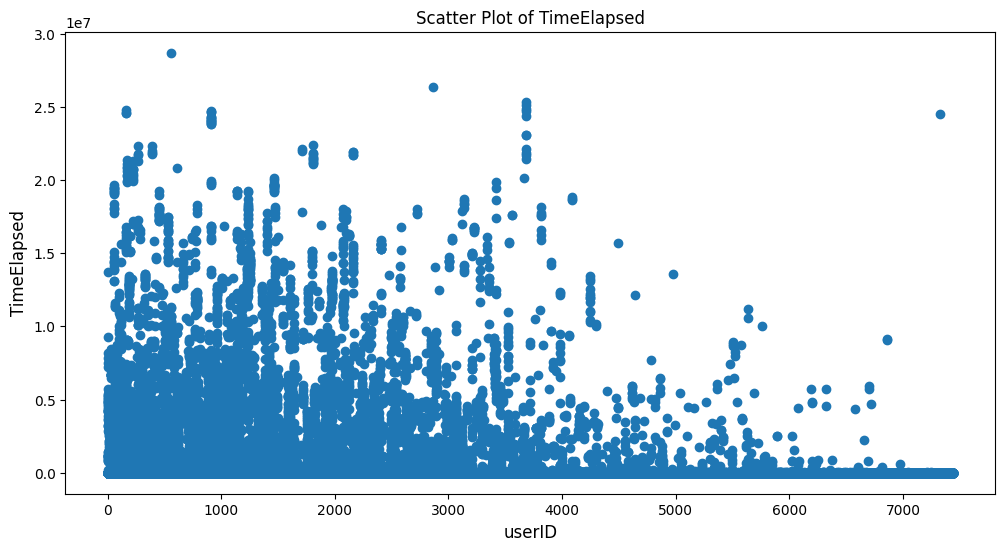

In [7]:
plt.figure(figsize=(12,6))
plt.scatter(x=train_test_dataset['userID'], y=train_test_dataset['TimeElapsed'])
plt.xlabel('userID', fontsize = 12)
plt.ylabel('TimeElapsed', fontsize = 12)
plt.title('Scatter Plot of TimeElapsed')
plt.show()

## - 1%의 상위 Outlier 제거 [사용 안함]

In [8]:
# train_test_dataset[train_test_dataset['TimeElapsed'] >= train_test_dataset['TimeElapsed'].quantile(0.99)].sort_values('TimeElapsed', ascending=False)
# train_test_dataset.loc[train_test_dataset['TimeElapsed'] >= train_test_dataset['TimeElapsed'].quantile(0.99), 'TimeElapsed'] = float('nan')

## - 사분위수 기준 Outlier 제거

In [9]:
# 이상치 처리 함수
def _handle_outliers(df: pd.DataFrame, column: str)->pd.DataFrame:
    # 사분위수 계산
    q1 = df[column].quantile(0.25)
    q2 = df[column].quantile(0.5)  # 추가: 중위값 - 사용은 안함
    q3 = df[column].quantile(0.75)
    
    # IQR 계산
    iqr = q3 - q1
    
    # 상위 이상치 처리
    upper_bound = q3 + 1.5 * iqr
    df[column] = df[column].apply(lambda x: np.nan if x > upper_bound else x)
    print(f"q1: {q1}, q2: {q2}, q3: {q3}, iqr: {iqr}, upper_bound: {upper_bound}")
    return df

train_test_dataset = _handle_outliers(train_test_dataset, 'TimeElapsed')

q1: 10.0, q2: 27.0, q3: 66.0, iqr: 56.0, upper_bound: 150.0


## - 신뢰구간 95%

In [10]:
from scipy.stats import t
def _calculate_confidence_interval(df: pd.DataFrame, target_column:str, confidence_level=0.95)-> tuple:
    # 평균과 표준편차 계산
    mean = df[target_column].mean()
    std = df[target_column].std()

    # 데이터 개수와 신뢰수준 설정
    n = len(df)

    # 신뢰구간 계산
    t_critical = t.ppf((1 + confidence_level) / 2, df=n-1)
    margin_of_error = t_critical * std / np.sqrt(n)
    confidence_interval = (mean - margin_of_error, mean + margin_of_error)

    print("Mean:", mean)
    print("Standard Deviation:", std)
    print("Confidence Interval ({}%):".format(confidence_level * 100), confidence_interval)

    return confidence_interval

Mean: 34.22725368509248
Standard Deviation: 33.77893776146775
Confidence Interval (95.0%): (34.185603450952044, 34.26890391923291)


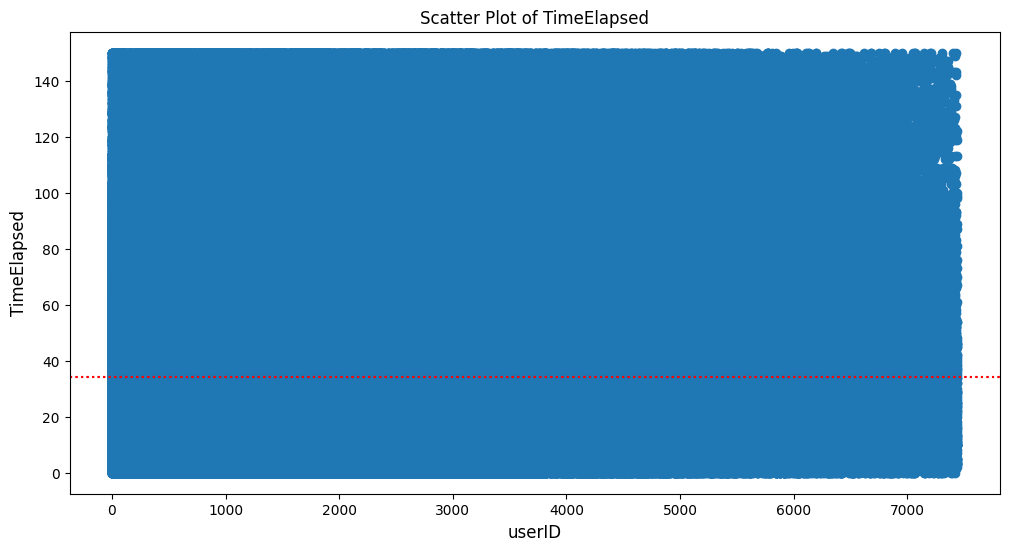

In [11]:
confidence_interval = _calculate_confidence_interval(train_test_dataset, 'TimeElapsed', 0.95)

plt.figure(figsize=(12,6))
plt.scatter(x=train_test_dataset['userID'], y=train_test_dataset['TimeElapsed'])
plt.xlabel('userID', fontsize = 12)
plt.ylabel('TimeElapsed', fontsize = 12)
plt.axhline(confidence_interval[0], color = 'r', linestyle = ':')
plt.axhline(confidence_interval[1], color = 'r', linestyle = ':')
plt.title('Scatter Plot of TimeElapsed')
plt.show()

Mean: 34.22725368509248
Standard Deviation: 33.77893776146775
Confidence Interval (95.0%): (34.185603450952044, 34.26890391923291)


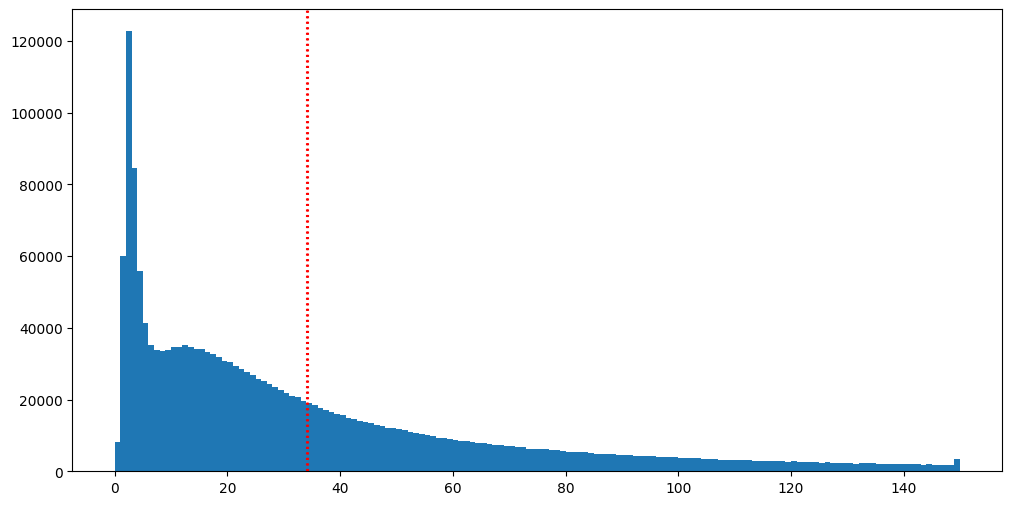

In [12]:
confidence_interval = _calculate_confidence_interval(train_test_dataset, 'TimeElapsed', 0.95)
plt.figure(figsize=(12,6))
plt.hist(train_test_dataset['TimeElapsed'], bins = int(train_test_dataset['TimeElapsed'].max()))
plt.axvline(confidence_interval[0], color = 'r', linestyle = ':')
plt.axvline(confidence_interval[1], color = 'r', linestyle = ':')
plt.show()

# TimeElapsed 결측치 채우기

---

> `userID`,	`assessmentItemID`,	`testId`, `KnowledgeTag`, `LargeCategory`를 기준으로 각 피처당 `TimeElapsed` 평균 값으로 새 피처 생성
> 
> - 결측치 연산 제외 피처 [`LargeCategory`]
>
>   1-9 범위로 이루어져 있어 정밀화에 방해를 줄 수 있다

In [13]:
train_test_dataset.isna().sum()

userID                   0
assessmentItemID         0
testId                   0
answerCode               0
Timestamp                0
KnowledgeTag             0
test_num                 0
question_num             0
LargeCategory            0
TimeElapsed         626612
dtype: int64

In [14]:
def _fill_nan_process(dataset: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    for name in columns_list:
        create_column_name = name + '_time_average'
        time_average = dataset.groupby(name)['TimeElapsed'].mean()
        dataset[create_column_name] = train_test_dataset[name].map(time_average)
    return dataset

columns = ['userID', 'assessmentItemID', 'testId', 'KnowledgeTag', 'LargeCategory']
train_test_dataset = _fill_nan_process(train_test_dataset, columns)

## - 결측치 확인

In [15]:
train_test_dataset.isna().sum()

userID                                0
assessmentItemID                      0
testId                                0
answerCode                            0
Timestamp                             0
KnowledgeTag                          0
test_num                              0
question_num                          0
LargeCategory                         0
TimeElapsed                      626612
userID_time_average                   0
assessmentItemID_time_average      7050
testId_time_average                   0
KnowledgeTag_time_average             0
LargeCategory_time_average            0
dtype: int64

## - 결측치 처리 [선형회귀 모델 사용]

> 먼저 `assessmentItemID_time_average`의 결측치를 치운 후 `ItemID_time_average`의 값을 함께 포함한 평균으로 `TimeElapsed`를 채운다
>
> 결측치가 없는 행과 변수들을 활용하여 회귀 모델 피팅

In [16]:
from sklearn.linear_model import LinearRegression
def _predict_missing_with_regression(df, target_column):
    # 결측치가 없는 행과 변수들을 활용하여 회귀 모델 피팅
    train_data = df.dropna()
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]
    model = LinearRegression()
    model.fit(X, y)
    
    # 결측치를 예측하기 위해 회귀 모델을 활용
    missing_data = df[df[target_column].isnull()].drop(columns=[target_column])
    predicted_values = model.predict(missing_data)
    
    # 예측된 값으로 결측치 채우기
    df.loc[df[target_column].isnull(), target_column] = predicted_values
    
    # 0 미만의 값들을 0으로 처리
    df.loc[df[target_column] < 0, target_column] = 0
    return df[target_column]

# 결측치 예측 및 채우기
df = train_test_dataset[['userID_time_average', 'assessmentItemID_time_average',
                         'testId_time_average', 'KnowledgeTag_time_average',
                         'LargeCategory_time_average']]
train_test_dataset['assessmentItemID_time_average'] = _predict_missing_with_regression(df, 'assessmentItemID_time_average')

df = train_test_dataset[['TimeElapsed', 'userID_time_average',
                         'assessmentItemID_time_average', 'testId_time_average',
                         'KnowledgeTag_time_average', 'LargeCategory_time_average']]
train_test_dataset['TimeElapsed'] = _predict_missing_with_regression(df, 'TimeElapsed').astype(int)

In [17]:
# 각각 columns의 평균으로 결측치를 채우는 
# mean_values = train_test_dataset[['userID_time_average', 'testId_time_average', 'KnowledgeTag_time_average']].mean(axis=1)
# train_test_dataset['assessmentItemID_time_average'].fillna(mean_values, inplace=True)

# mean_values = train_test_dataset[['userID_time_average', 'assessmentItemID_time_average', 'testId_time_average', 'KnowledgeTag_time_average']].mean(axis=1)
# train_test_dataset['TimeElapsed'].fillna(mean_values, inplace=True)

## - 결측치 처리 완료

In [18]:
# TimeElapsed 정수화
train_test_dataset['TimeElapsed'] = train_test_dataset['TimeElapsed'].astype(int)
# 계산이 끝난 columns 제거
train_test_dataset.drop(['userID_time_average', 'assessmentItemID_time_average', 'testId_time_average', 'KnowledgeTag_time_average', 'LargeCategory_time_average'], axis=1, inplace=True)
train_test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,3
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,8
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,3,6,7
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,4,6,7
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,5,6,11
...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,130,1,4,18
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,130,2,4,21
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,130,3,4,89
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,130,4,4,32


Mean: 33.83793445996755
Standard Deviation: 30.874327640807945
Confidence Interval (95.0%): (33.79986567923061, 33.87600324070449)


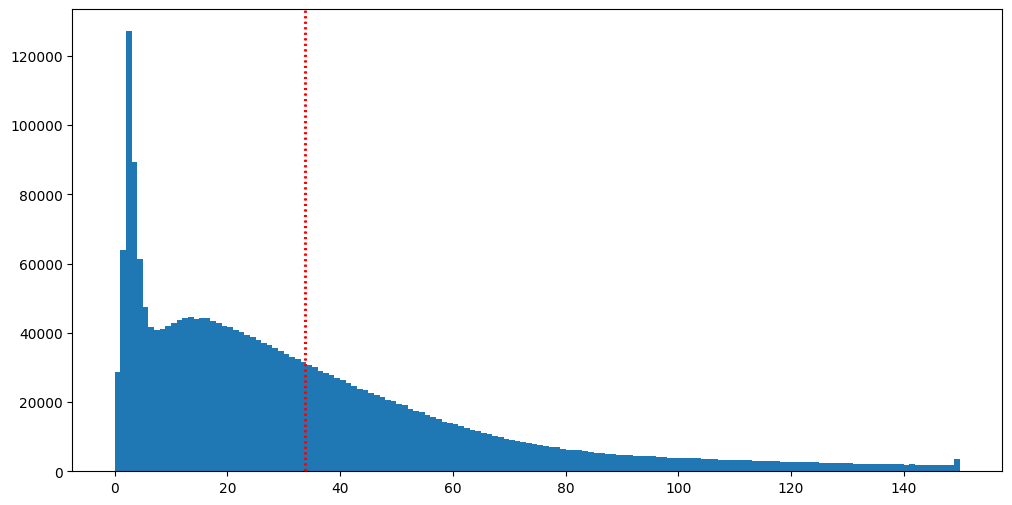

In [19]:
confidence_interval = _calculate_confidence_interval(train_test_dataset, 'TimeElapsed', 0.95)
plt.figure(figsize=(12,6))
plt.hist(train_test_dataset['TimeElapsed'], bins = int(train_test_dataset['TimeElapsed'].max()))
plt.axvline(confidence_interval[0], color = 'r', linestyle = ':')
plt.axvline(confidence_interval[1], color = 'r', linestyle = ':')
plt.show()

## - TimeElapsed_category 생성

In [20]:
# 10을 기준으로 카테로리 생성 [0 ~ 15] 범위
train_test_dataset['TimeElapsed_category'] = train_test_dataset['TimeElapsed'] // 10
sorted(train_test_dataset['TimeElapsed_category'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

---
<br>
<br>

---
<br>

# FeatureEngineering 시작

---

> 우선적으로 answerCode의 -1을 nan으로 처리하여 함께 평균에 포함되어 연산되지 않도록 한다

In [21]:
# -1 값을 NaN으로 대체하는 코드
train_test_dataset['answerCode'] = np.where(train_test_dataset['answerCode'] == -1, np.nan, train_test_dataset['answerCode'])
train_test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category
0,0,A060001001,A060000001,1.0,2020-03-24 00:17:11,7224,1,1,6,3,0
1,0,A060001002,A060000001,1.0,2020-03-24 00:17:14,7225,1,2,6,8,0
2,0,A060001003,A060000001,1.0,2020-03-24 00:17:22,7225,1,3,6,7,0
3,0,A060001004,A060000001,1.0,2020-03-24 00:17:29,7225,1,4,6,7,0
4,0,A060001005,A060000001,1.0,2020-03-24 00:17:36,7225,1,5,6,11,1
...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0.0,2020-10-14 23:07:23,8832,130,1,4,18,1
2526696,7439,A040130002,A040000130,1.0,2020-10-14 23:07:41,8832,130,2,4,21,2
2526697,7439,A040130003,A040000130,1.0,2020-10-14 23:08:02,8244,130,3,4,89,8
2526698,7439,A040130004,A040000130,1.0,2020-10-14 23:09:31,8244,130,4,4,32,3


## - Timestamp

In [22]:
def _datetime_process(df: pd.DataFrame):
    # 년도 (Year) 추출
    df['year'] = df['Timestamp'].dt.year
    # 월 (Month) 추출
    df['month'] = df['Timestamp'].dt.month
    # 일 (Day) 추출
    df['day'] = df['Timestamp'].dt.day
    # 요일 (Weekday) 추출 - [0~6] 월 ~ 일
    df['weekday'] = df['Timestamp'].dt.weekday
    # 시간 (hour) 추출
    df['hour'] = df['Timestamp'].dt.hour
    return df

train_test_dataset = _datetime_process(train_test_dataset)
train_test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour
0,0,A060001001,A060000001,1.0,2020-03-24 00:17:11,7224,1,1,6,3,0,2020,3,24,1,0
1,0,A060001002,A060000001,1.0,2020-03-24 00:17:14,7225,1,2,6,8,0,2020,3,24,1,0
2,0,A060001003,A060000001,1.0,2020-03-24 00:17:22,7225,1,3,6,7,0,2020,3,24,1,0
3,0,A060001004,A060000001,1.0,2020-03-24 00:17:29,7225,1,4,6,7,0,2020,3,24,1,0
4,0,A060001005,A060000001,1.0,2020-03-24 00:17:36,7225,1,5,6,11,1,2020,3,24,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0.0,2020-10-14 23:07:23,8832,130,1,4,18,1,2020,10,14,2,23
2526696,7439,A040130002,A040000130,1.0,2020-10-14 23:07:41,8832,130,2,4,21,2,2020,10,14,2,23
2526697,7439,A040130003,A040000130,1.0,2020-10-14 23:08:02,8244,130,3,4,89,8,2020,10,14,2,23
2526698,7439,A040130004,A040000130,1.0,2020-10-14 23:09:31,8244,130,4,4,32,3,2020,10,14,2,23


# **🔥🔥 - Main function 🔥🔥**

#### **가장 중요한 함수**
> 
> _columns_to_mean_score(df: 데이터프레임, columns_list: 리스트) -> 데이터프레임:
>
> - columns_list 규칙 - *_mean
>
>    
>    userID_mean - 같은 유저 아이디별 평균 점수
>
>    userID_assessmentItemID_mean - 같은 유저의 같은 문제 평균 점수
>
>    userID_testId_mean - 같은 유저의 같은 시험지 평균 점수

In [23]:
def _columns_to_mean_score(df: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    create_column_name = '_'.join(columns_list) + '_mean'
    # DataFrame을 columns_list로 그룹화한 후, answerCode 열의 평균을 계산하여 새로운 DataFrame average_data를 생성
    average_data = df.groupby(columns_list)['answerCode'].mean().reset_index()
    # average_data DataFrame의 answerCode 열의 이름을 create_column_name으로 변경
    average_data.rename(columns={'answerCode': create_column_name}, inplace=True)

    # 평균치라서 결측치는 0.5로 채움
    # average_data = average_data.fillna(0.5)
    
    # df와 average_data를 columns_list를 기준으로 left 조인하여 병합
    df = pd.merge(df, average_data, on=columns_list, how='left')
    return df

## - FeatureEngineering

> userID, assessmentItemID, testId, KnowledgeTag, LargeCategory, TimeElapsed_category, weekday,	hour 활용
>
> answerCode를 통해 평균 계산

### 1. userID 기반

In [24]:
# 같은 유저의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID'])
# 같은 유저의 정답 평균을 구하고 추가로 중복을 없앤 유저의 평균
train_test_dataset['userID_average'] = train_test_dataset.groupby('userID')['userID_mean'].mean().mean()
# 같은 유저의 같은 문제 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'assessmentItemID'])
# 같은 유저의 같은 시험지 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'testId'])
# 같은 유저의 같은 태그 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'KnowledgeTag'])
# 같은 유저의 같은 대분류 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'LargeCategory'])
# 같은 유저의 같은 시간 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'TimeElapsed_category'])
# 같은 유저의 같은 요일 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'weekday'])
# 같은 유저의 같은 시간 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['userID', 'hour'])

### 2. assessmentItemID 기반

In [25]:
# 같은 문제의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['assessmentItemID'])

### 3. testId 기반

In [26]:
# 같은 시험지의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['testId'])

### 4. KnowledgeTag 기반

In [27]:
# 같은 태그의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['KnowledgeTag'])

### 5. LargeCategory 기반

In [28]:
# 같은 대분류의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['LargeCategory'])

### 6. TimeElapsed_category 기반

In [29]:
# 같은 시간_카테고리의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['TimeElapsed_category'])

### 7. weekday 기반

In [30]:
# 같은 요일의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['weekday'])

### 8. hour 기반

In [31]:
# 같은 시간의 정답 평균
train_test_dataset = _columns_to_mean_score(train_test_dataset, ['hour'])

## - category로 변환

> 유저가 평균보다 높은 경우 2
>
> 유저가 평균과 같거나 nan이라서 판별이 안될경우 1
>
> 유저가 평균보다 떨어지는 경우 0

In [32]:
def _compare_make_category(df: pd.DataFrame, columns_1: str, columns_2: str)->pd.DataFrame:
    # 비교 대상에 nan이 들어가면 1로 채움
    # columns_1이 더크면 2를 넣음
    # columns_1과 columns2가 같으면 1을 넣음
    # columns_1이 더 작으면 0을 넣음
    df[columns_1.replace('_mean','')+'_category'] = np.where(df[columns_1].isna() | df[columns_2].isna(), 1,
                                                    np.where(df[columns_1] > df[columns_2], 2,
                                                    np.where(df[columns_1] == df[columns_2], 1, 0)))
    return df

In [33]:
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_mean', 'userID_average')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_assessmentItemID_mean', 'assessmentItemID_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_testId_mean', 'testId_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_KnowledgeTag_mean', 'KnowledgeTag_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_LargeCategory_mean', 'LargeCategory_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_TimeElapsed_category_mean', 'TimeElapsed_category_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_weekday_mean', 'weekday_mean')
train_test_dataset = _compare_make_category(train_test_dataset, 'userID_hour_mean', 'hour_mean')

## - 전처리 완료

In [34]:
train_test_dataset.isna().sum()

userID                                    0
assessmentItemID                          0
testId                                    0
answerCode                              744
Timestamp                                 0
KnowledgeTag                              0
test_num                                  0
question_num                              0
LargeCategory                             0
TimeElapsed                               0
TimeElapsed_category                      0
year                                      0
month                                     0
day                                       0
weekday                                   0
hour                                      0
userID_mean                               0
userID_average                            0
userID_assessmentItemID_mean            732
userID_testId_mean                        0
userID_KnowledgeTag_mean                 47
userID_LargeCategory_mean                 0
userID_TimeElapsed_category_mean

> `answerCode`의 nan값을 -1로 되돌리는 코드

In [35]:
train_test_dataset['answerCode'] = train_test_dataset['answerCode'].fillna(-1)
train_test_dataset['answerCode'] = train_test_dataset['answerCode'].astype(int)

> 나머지 값들은 평균 판단이 nan이여서 생긴 결측치 이므로 정답 라벨 0,1의 중위값인 0.5로 결측치 제거

In [36]:
train_test_dataset = train_test_dataset.fillna(0.5)

In [37]:
train_test_dataset.isna().sum()

userID                                  0
assessmentItemID                        0
testId                                  0
answerCode                              0
Timestamp                               0
KnowledgeTag                            0
test_num                                0
question_num                            0
LargeCategory                           0
TimeElapsed                             0
TimeElapsed_category                    0
year                                    0
month                                   0
day                                     0
weekday                                 0
hour                                    0
userID_mean                             0
userID_average                          0
userID_assessmentItemID_mean            0
userID_testId_mean                      0
userID_KnowledgeTag_mean                0
userID_LargeCategory_mean               0
userID_TimeElapsed_category_mean        0
userID_weekday_mean               

### - year, month, day, weekday, hour: dtypes 통일

In [38]:
train_test_dataset[['year', 'month', 'day', 'weekday', 'hour']] = train_test_dataset[['year', 'month', 'day', 'weekday', 'hour']].astype(int)

In [39]:
train_test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2526700 entries, 0 to 2526699
Data columns (total 40 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   userID                                int64         
 1   assessmentItemID                      object        
 2   testId                                object        
 3   answerCode                            int64         
 4   Timestamp                             datetime64[ns]
 5   KnowledgeTag                          int64         
 6   test_num                              int64         
 7   question_num                          int64         
 8   LargeCategory                         int64         
 9   TimeElapsed                           int64         
 10  TimeElapsed_category                  int64         
 11  year                                  int64         
 12  month                                 int64         
 13  day         

# 동현 전처리

---

In [40]:
train_test_dataset['answerCode'] = train_test_dataset['answerCode'].fillna(-1)
train_test_dataset['answerCode'] = train_test_dataset['answerCode'].replace(-1, np.nan)

## - assessmentItemID solve count 

In [41]:
train_test_dataset['correct_ItemID_count'] = train_test_dataset.groupby(['userID', 'assessmentItemID'])['answerCode'].cumsum()
train_test_dataset['whole_ItemID_count'] = train_test_dataset.groupby(['userID', 'assessmentItemID'])['answerCode'].cumcount() + 1
train_test_dataset['incorrect_ItemID_count'] = train_test_dataset['whole_ItemID_count'] - train_test_dataset['correct_ItemID_count']

## - tag solve count 

In [42]:
train_test_dataset['correct_tag_count'] = train_test_dataset.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumsum()
train_test_dataset['whole_tag_count'] = train_test_dataset.groupby(['userID', 'KnowledgeTag'])['answerCode'].cumcount() + 1
train_test_dataset['incorrect_tag_count'] = train_test_dataset['whole_tag_count'] - train_test_dataset['correct_tag_count']

## - Time

In [43]:
def _columns_to_mean_score_time(df: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    create_column_name = '_'.join(columns_list) + '_time_mean'
    # DataFrame을 columns_list로 그룹화한 후, answerCode 열의 평균을 계산하여 새로운 DataFrame average_data를 생성
    average_data = df.groupby(columns_list)['TimeElapsed'].mean().reset_index()
    # average_data DataFrame의 answerCode 열의 이름을 create_column_name으로 변경
    average_data.rename(columns={'TimeElapsed': create_column_name}, inplace=True)

    # 평균치라서 결측치는 0.5로 채움
    # average_data = average_data.fillna(0.5)
    
    # df와 average_data를 columns_list를 기준으로 left 조인하여 병합
    df = pd.merge(df, average_data, on=columns_list, how='left')
    return df

train_test_dataset = _columns_to_mean_score_time(train_test_dataset, ['userID'])
train_test_dataset = _columns_to_mean_score_time(train_test_dataset, ['assessmentItemID'])
train_test_dataset = _columns_to_mean_score_time(train_test_dataset, ['testId'])
train_test_dataset = _columns_to_mean_score_time(train_test_dataset, ['KnowledgeTag'])

In [44]:
train_test_dataset.isna().sum()

userID                                    0
assessmentItemID                          0
testId                                    0
answerCode                              744
Timestamp                                 0
KnowledgeTag                              0
test_num                                  0
question_num                              0
LargeCategory                             0
TimeElapsed                               0
TimeElapsed_category                      0
year                                      0
month                                     0
day                                       0
weekday                                   0
hour                                      0
userID_mean                               0
userID_average                            0
userID_assessmentItemID_mean              0
userID_testId_mean                        0
userID_KnowledgeTag_mean                  0
userID_LargeCategory_mean                 0
userID_TimeElapsed_category_mean

## - 결측치 처리 0으로 채움
> correct_ItemID_count, incorrect_ItemID_count, correct_tag_count, incorrect_tag_count

In [45]:
train_test_dataset[['correct_ItemID_count', 'incorrect_ItemID_count', 'correct_tag_count', 'incorrect_tag_count']] = train_test_dataset[['correct_ItemID_count', 'incorrect_ItemID_count', 'correct_tag_count', 'incorrect_tag_count']].fillna(0)

In [46]:
df = train_test_dataset.copy()
df['last_answerCode1'] = df.groupby('userID')['answerCode'].shift(1).fillna(method='bfill')
df['last_answerCode2'] = df.groupby("userID")['answerCode'].shift(2).fillna(method='bfill')
df['last_answerCode3'] = df.groupby("userID")['answerCode'].shift(3).fillna(method='bfill')
df['last_answerCode4'] = df.groupby("userID")['answerCode'].shift(4).fillna(method='bfill')
df['last_answerCode5'] = df.groupby("userID")['answerCode'].shift(5).fillna(method='bfill')
df['last_answerCode6'] = df.groupby("userID")['answerCode'].shift(6).fillna(method='bfill')
df['last_answerCode7'] = df.groupby("userID")['answerCode'].shift(7).fillna(method='bfill')
df['last_answerCode8'] = df.groupby("userID")['answerCode'].shift(8).fillna(method='bfill')
df['last_answerCode9'] = df.groupby("userID")['answerCode'].shift(9).fillna(method='bfill').fillna(1)
df['last_answerCode10'] = df.groupby("userID")['answerCode'].shift(10).fillna(method='bfill').fillna(1)

df['last_answerCode1'] = df['last_answerCode1'].astype(int)
df['last_answerCode2'] = df['last_answerCode2'].astype(int)
df['last_answerCode3'] = df['last_answerCode3'].astype(int)
df['last_answerCode4'] = df['last_answerCode4'].astype(int)
df['last_answerCode5'] = df['last_answerCode5'].astype(int)
df['last_answerCode6'] = df['last_answerCode6'].astype(int)
df['last_answerCode7'] = df['last_answerCode7'].astype(int)
df['last_answerCode8'] = df['last_answerCode8'].astype(int)
df['last_answerCode9'] = df['last_answerCode9'].astype(int)
df['last_answerCode10'] = df['last_answerCode10'].astype(int)
train_test_dataset = df.copy()

# - 선우 전처리

---

In [47]:
# 각 문제에서 드러난 학생의 실력
df = train_test_dataset.copy()
accuracy_by_aid = df.groupby('assessmentItemID')['answerCode'].mean() # 문제 평균 정답률
df['accuracy_avg_by_aid'] = df['assessmentItemID'].map(accuracy_by_aid)
df['relative_correct_aid'] = df['answerCode'] - df['accuracy_avg_by_aid']
aid_mean =  df.groupby(['userID'])['relative_correct_aid'].agg('mean')
df['relative_avg_correct_aid'] = df['userID'].map(aid_mean)

# 각 태그에서 드러난 학생의 실력
accuracy_by_tags = df.groupby('KnowledgeTag')['answerCode'].mean() # 태그 평균 정답률
df['accuracy_avg_by_tags'] = df['KnowledgeTag'].map(accuracy_by_tags)
df['relative_correct_tags'] = df['answerCode'] - df['accuracy_avg_by_tags']
tags_mean = df.groupby(['userID'])['relative_correct_tags'].agg('mean')
df['relative_avg_correct_tags'] = df['userID'].map(tags_mean)

train_test_dataset = df.copy()

In [48]:
def _predict_missing_with_regression_relative_prediction(df, target_column):
    # 결측치가 없는 행과 변수들을 활용하여 회귀 모델 피팅
    train_data = df.dropna()
    X = train_data.drop(columns=[target_column])
    y = train_data[target_column]
    model = LinearRegression()
    model.fit(X, y)
    
    # 결측치를 예측하기 위해 회귀 모델을 활용
    missing_data = df[df[target_column].isnull()].drop(columns=[target_column])
    predicted_values = model.predict(missing_data)
    
    # 예측된 값으로 결측치 채우기
    df.loc[df[target_column].isnull(), target_column] = predicted_values
    
    return df[target_column]

In [49]:
df = train_test_dataset[['accuracy_avg_by_aid', 'relative_avg_correct_aid', 'relative_correct_aid']].copy()
train_test_dataset['relative_correct_aid'] = _predict_missing_with_regression_relative_prediction(df, 'relative_correct_aid')

df = train_test_dataset[['accuracy_avg_by_tags', 'relative_avg_correct_tags', 'relative_correct_tags']].copy()
train_test_dataset['relative_correct_tags'] = _predict_missing_with_regression_relative_prediction(df, 'relative_correct_tags')

## - type 변환

---

In [50]:
train_test_dataset['correct_ItemID_count'] =  train_test_dataset['correct_ItemID_count'].astype(int)
train_test_dataset['incorrect_ItemID_count'] =  train_test_dataset['incorrect_ItemID_count'].astype(int)
train_test_dataset['correct_tag_count'] =  train_test_dataset['correct_tag_count'].astype(int)
train_test_dataset['incorrect_tag_count'] =  train_test_dataset['incorrect_tag_count'].astype(int)

In [51]:
train_test_dataset = train_test_dataset.fillna(-1)
train_test_dataset['answerCode'] =  train_test_dataset['answerCode'].astype(int)

# combined_dataset / submission_dataset - 분리

---

> - combined_dataset : 전체 데이터 셋
>
>   ML학습을 위해서 시계열 데이터를 개별적으로 학습을 가능하게 하기 위해 변경  
>   학습 시에 별도로 train/test 나누는 단계가 필요
> 
> - submission_dataset : 제출을 위한 모델 인풋 데이터셋

In [52]:
combined_dataset = train_test_dataset[train_test_dataset['answerCode'] != -1].reset_index(drop=True)
submission_dataset = train_test_dataset[train_test_dataset['answerCode'] == -1].reset_index(drop=True)

In [53]:
combined_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,3,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.000000,1.000000,0.791908,0.431925,0.707317,0.652778,0.984000,0.952667,0.957333,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,10.564000,17.906667,12.464000,1,1,1,1,1,1,1,1,1,1,0.984000,0.016000,-0.024348,0.957333,0.042667,0.028795
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,8,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.000000,1.000000,0.791908,0.431925,0.707317,0.652778,0.968000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,19.948000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.968000,0.032000,-0.024348,0.917067,0.082933,0.028795
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,3,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.000000,1.000000,0.791908,0.431925,0.707317,0.652778,0.916000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,2,2,0,30.097987,17.640000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.916000,0.084000,-0.024348,0.917067,0.082933,0.028795
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,4,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.000000,1.000000,0.791908,0.431925,0.707317,0.652778,0.972000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,3,3,0,30.097987,14.108000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.972000,0.028000,-0.024348,0.917067,0.082933,0.028795
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,5,6,11,1,2020,3,24,1,0,0.630872,0.628749,1.0,1.000000,1.000000,0.791908,0.729032,0.707317,0.652778,0.948000,0.952667,0.917067,0.712279,0.712584,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,4,4,0,30.097987,27.872000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.948000,0.052000,-0.024348,0.917067,0.082933,0.028795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,197,6,4,8,0,2020,8,21,4,7,0.733333,0.628749,1.0,0.666667,0.666667,0.733333,0.666667,0.666667,0.666667,0.953020,0.773081,0.765016,0.680256,0.373141,0.644207,0.642030,2,2,0,0,2,2,2,2,1,1,0,4,6,2,27.437500,11.710000,21.172778,24.449474,0,0,1,1,1,0,1,1,1,1,0.953020,0.046980,-0.025535,0.765016,0.234984,-0.036961
2525952,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,130,1,4,18,1,2020,10,14,2,23,0.733333,0.628749,0.0,0.750000,0.500000,0.733333,0.500000,0.750000,0.750000,0.436667,0.640427,0.638385,0.680256,0.712584,0.641419,0.659126,2,0,2,0,2,0,2,2,0,1,1,0,1,1,27.437500,38.313333,35.032667,32.133333,1,0,0,1,1,1,0,1,1,1,0.436667,-0.436667,-0.025535,0.638385,-0.638385,

In [54]:
submission_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,3,A050133008,A050000133,-1,2020-10-26 13:13:57,5289,133,8,5,36,3,2020,10,26,0,13,0.692754,0.628749,0.5,0.857143,0.818182,0.655052,0.733871,0.578512,0.696335,0.534137,0.655328,0.559557,0.659098,0.737629,0.676815,0.705563,2,1,2,2,0,0,0,0,0,1,0,0,12,0,36.609073,35.808000,43.908500,46.451077,0,1,1,1,1,1,1,0,1,1,0.534137,0.022655,0.022928,0.559557,0.021827,0.022950
1,4,A070146008,A070000146,-1,2020-12-27 02:47:54,9080,146,8,7,43,4,2020,12,27,6,2,0.694030,0.628749,0.5,0.857143,0.666667,0.703529,0.684211,0.697479,0.707865,0.613793,0.651883,0.546420,0.521761,0.743733,0.674797,0.642481,2,1,2,2,2,0,2,2,0,1,0,0,4,0,46.710879,32.993333,40.849167,28.865490,1,1,1,1,0,1,1,0,0,1,0.613793,0.082662,0.082753,0.546420,0.107613,0.108879
2,13,A070111008,A070000111,-1,2020-12-27 04:35:09,9660,111,8,7,16,1,2020,12,27,6,4,0.695289,0.628749,0.5,0.428571,0.333333,0.390593,0.712551,0.584270,0.555556,0.369478,0.456728,0.494326,0.521761,0.712584,0.674797,0.633794,2,1,0,0,0,0,0,0,0,1,0,0,7,0,33.243736,12.676000,22.793500,24.109000,1,0,0,0,1,1,0,1,0,0,0.369478,0.046799,0.047443,0.494326,0.030775,0.032670
3,17,A090064006,A090000064,-1,2020-10-30 05:48:37,2611,64,6,9,43,4,2020,10,30,4,5,0.818904,0.628749,0.5,1.000000,1.000000,0.924757,0.764706,0.861953,0.739837,0.272727,0.445743,0.419317,0.454680,0.743733,0.644207,0.625137,2,1,2,2,2,2,2,2,0,1,0,0,6,0,46.022222,26.920000,27.540000,23.970588,1,1,1,1,1,1,1,1,1,1,0.272727,0.194568,0.195429,0.419317,0.188795,0.191554
4,26,A060135007,A060000135,-1,2020-10-23 11:44:18,1422,135,7,6,34,3,2020,10,23,4,11,0.759067,0.628749,0.5,0.666667,0.666667,0.817365,0.649123,0.872611,0.892857,0.313253,0.640366,0.609602,0.712279,0.737629,0.644207,0.710473,2,1,2,2,2,0,2,2,0,1,0,0,7,0,33.925065,34.632000,35.013714,40.462105,0,1,0,1,1,1,1,1,1,1,0.313253,0.057924,0.058694,0.609602,0.048657,0.049183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7395,A040122005,A040000122,-1,2020-09-08 02:05:20,10615,122,5,4,14,1,2020,9,8,1,2,0.304348,0.628749,0.5,0.250000,0.000000,0.111111,0.666667,0.250000,0.250000,0.448161,0.791194,0.701763,0.680256,0.712584,0.667339,0.642481,0,1,0,0,0,0,0,0,0,1,0,0,3,0,12.375000,35.566667,34.606667,28.884762,0,0,1,0,0,0,0,0,0,0,0.448161,-0.379638,-0.379167,0.701763,-0.308705,-0.309215
740,7404,A030111005,A030000111,-1,2020-10-13 09:49:18,7636,111,5,3,22,2,2020,10,13,1,9,0.500000,0.628749,0.5,0.500000,0.500000,0.500000,0.333333,0.500000,0.500000,0.886288,0.867245,0.824547,0.702210,0.731786,0.667339,0.683592,0,1,0,0,0,0,0,0,0,1,0,0,5,0,32.933333,20.316667,28.767333,31.280000,1,1,0,0,0,1,0,0,0,1,0.886288,-0.262813,-0.263333

## - ML dataset csv save/load

In [55]:
# save csv
combined_dataset.to_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_ml_dataset/Main_Dataset/dataset_all_data.csv', index=False)
submission_dataset.to_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_ml_dataset/Main_Dataset/submission_all_data.csv', index=False)

In [56]:
# load csv
combined_dataset = pd.read_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_ml_dataset/Main_Dataset/dataset_all_data.csv')
submission_dataset = pd.read_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_ml_dataset/Main_Dataset/submission_all_data.csv')

## - Seqeunce 데이터 학습을 위한 dataset 변환

In [57]:
train_dataset = combined_dataset[~combined_dataset['userID'].isin(submission_dataset['userID'].unique())]
train_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,3,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.984000,0.952667,0.957333,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,10.564000,17.906667,12.464000,1,1,1,1,1,1,1,1,1,1,0.984000,0.016000,-0.024348,0.957333,0.042667,0.028795
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,8,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.968000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,19.948000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.968000,0.032000,-0.024348,0.917067,0.082933,0.028795
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,3,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.916000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,2,2,0,30.097987,17.640000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.916000,0.084000,-0.024348,0.917067,0.082933,0.028795
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,4,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.972000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,3,3,0,30.097987,14.108000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.972000,0.028000,-0.024348,0.917067,0.082933,0.028795
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,5,6,11,1,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.729032,0.707317,0.652778,0.948000,0.952667,0.917067,0.712279,0.712584,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,4,4,0,30.097987,27.872000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.948000,0.052000,-0.024348,0.917067,0.082933,0.028795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,71,5,3,41,4,2020,6,5,4,6,0.555556,0.628749,0.0,0.2,0.2,0.200000,0.333333,0.555556,0.200000,0.446667,0.666000,0.694889,0.702210,0.743733,0.644207,0.628854,0,0,0,0,0,0,0,0,0,1,1,1,5,4,46.555556,29.256667,38.448000,35.622889,0,1,0,0,0,0,0,0,1,1,0.446667,-0.446667,-0.105017,0.694889,-0.694889,-0.141618
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,165,1,4,11,1,2020,8,21,4,1,0.555556,0.628749,1.0,1.0,1.0,1.000000,1.000000,0.555556,1.000000,0.643333,0.653878,0.700029,0.680256,0.712584,0.644207,0.645166,0,2,2,2,2,2,0,2,1,1,0,1,1,0,46.555556,23.466667,33.143333,27.842899,0,0,1,0,0,0,0,0,1,1,0.643333,0.356667,-0.105017,0.700029,0.299971,-0.141618
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,16

In [58]:
test_dataset = pd.concat([submission_dataset, combined_dataset[combined_dataset['userID'].isin(submission_dataset['userID'])]], ignore_index=False)
test_dataset = test_dataset.sort_values(['userID','Timestamp', 'assessmentItemID']).reset_index(drop=True)
test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,23,1,5,26,2,2020,1,9,3,10,0.692754,0.628749,0.5,0.428571,0.714286,0.655052,0.731707,0.728448,0.619048,0.660000,0.549714,0.636571,0.659098,0.731786,0.658284,0.700482,2,0,0,2,0,0,2,0,1,1,0,1,1,0,36.609073,42.972000,36.422286,39.011429,1,1,1,1,1,1,1,1,1,1,0.660000,0.340000,0.022928,0.636571,0.363429,0.022950
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,23,2,5,94,9,2020,1,9,3,10,0.692754,0.628749,1.0,0.428571,0.714286,0.655052,0.888889,0.728448,0.619048,0.620000,0.549714,0.636571,0.659098,0.769290,0.658284,0.700482,2,2,0,2,0,2,2,0,1,1,0,2,2,0,36.609073,43.588000,36.422286,39.011429,1,1,1,1,1,1,1,1,1,1,0.620000,0.380000,0.022928,0.636571,0.363429,0.022950
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,23,3,5,5,0,2020,1,9,3,10,0.692754,0.628749,0.0,0.428571,0.166667,0.655052,0.512048,0.728448,0.619048,0.548000,0.549714,0.663200,0.659098,0.373141,0.658284,0.700482,2,0,0,0,0,2,2,0,0,1,1,0,1,1,36.609073,34.020000,36.422286,41.560800,1,1,1,1,1,1,1,1,1,1,0.548000,-0.548000,0.022928,0.663200,-0.663200,0.022950
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,23,4,5,7,0,2020,1,9,3,10,0.692754,0.628749,0.5,0.428571,0.166667,0.655052,0.512048,0.728448,0.619048,0.636000,0.549714,0.663200,0.659098,0.373141,0.658284,0.700482,2,0,0,0,0,2,2,0,0,1,1,0,2,2,36.609073,45.708000,36.422286,41.560800,0,1,1,1,1,1,1,1,1,1,0.636000,-0.636000,0.022928,0.663200,-0.663200,0.022950
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,23,6,5,3,0,2020,1,9,3,10,0.692754,0.628749,0.0,0.428571,0.600000,0.655052,0.512048,0.728448,0.619048,0.304000,0.549714,0.570222,0.659098,0.373141,0.658284,0.700482,2,0,0,2,0,2,2,0,0,1,1,0,1,1,36.609073,29.428000,36.422286,34.639556,0,0,1,1,1,1,1,1,1,1,0.304000,-0.304000,0.022928,0.570222,-0.570222,0.022950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,130,1,4,18,1,2020,10,14,2,23,0.733333,0.628749,0.0,0.750000,0.500000,0.733333,0.500000,0.750000,0.750000,0.436667,0.640427,0.638385,0.680256,0.712584,0.641419,0.659126,2,0,2,0,2,0,2,2,0,1,1,0,1,1,27.437500,38.313333,35.032667,32.133333,1,0,0,1,1,1,0,1,1,1,0.436667,-0.436667,-0.025535,0.638385,-0.638385,-0.036961
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,130,2,4,21,2,2020,10,14,2,23,0.733333,0.628749,1.0,0.750000,0.500000,0.733333,1.000000,0.750000,0.750000,0.483333,0.640427,0.638385,0.680256,0.731786,0.641419,0.659126,2,2,2,0,2,2,2,2,1,1,0,1,2,1,27.437500,25.503333,35.032667,32.133333,0,1,0,0,1,1,1,0,1,1,0.483333,0.516667,-0.025535,0.638385,0

## - Sequence dataset csv save/load

In [59]:
# save
train_dataset.to_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_sequence_dataset/Main_Dataset/train_dataset_all_data.csv', index=False)
test_dataset.to_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_sequence_dataset/Main_Dataset/test_dataset_all_data.csv', index=False)

In [60]:
# load csv
train_dataset = pd.read_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_sequence_dataset/Main_Dataset/train_dataset_all_data.csv')
test_dataset = pd.read_csv('/opt/ml/project/BoostCamp_DKT_Database/preprocess/J_sequence_dataset/Main_Dataset/test_dataset_all_data.csv')

In [61]:
train_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,1,6,3,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.984000,0.952667,0.957333,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,10.564000,17.906667,12.464000,1,1,1,1,1,1,1,1,1,1,0.984000,0.016000,-0.024348,0.957333,0.042667,0.028795
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1,2,6,8,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.968000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,1,1,0,30.097987,19.948000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.968000,0.032000,-0.024348,0.917067,0.082933,0.028795
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,1,3,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.916000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,2,2,0,30.097987,17.640000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.916000,0.084000,-0.024348,0.917067,0.082933,0.028795
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,1,4,6,7,0,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.431925,0.707317,0.652778,0.972000,0.952667,0.917067,0.712279,0.373141,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,3,3,0,30.097987,14.108000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.972000,0.028000,-0.024348,0.917067,0.082933,0.028795
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,1,5,6,11,1,2020,3,24,1,0,0.630872,0.628749,1.0,1.0,1.0,0.791908,0.729032,0.707317,0.652778,0.948000,0.952667,0.917067,0.712279,0.712584,0.667339,0.650799,2,2,2,2,2,2,2,2,1,1,0,4,4,0,30.097987,27.872000,17.906667,20.342667,1,1,1,1,1,1,1,1,1,1,0.948000,0.052000,-0.024348,0.917067,0.082933,0.028795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,71,5,3,41,4,2020,6,5,4,6,0.555556,0.628749,0.0,0.2,0.2,0.200000,0.333333,0.555556,0.200000,0.446667,0.666000,0.694889,0.702210,0.743733,0.644207,0.628854,0,0,0,0,0,0,0,0,0,1,1,1,5,4,46.555556,29.256667,38.448000,35.622889,0,1,0,0,0,0,0,0,1,1,0.446667,-0.446667,-0.105017,0.694889,-0.694889,-0.141618
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,165,1,4,11,1,2020,8,21,4,1,0.555556,0.628749,1.0,1.0,1.0,1.000000,1.000000,0.555556,1.000000,0.643333,0.653878,0.700029,0.680256,0.712584,0.644207,0.645166,0,2,2,2,2,2,0,2,1,1,0,1,1,0,46.555556,23.466667,33.143333,27.842899,0,0,1,0,0,0,0,0,1,1,0.643333,0.356667,-0.105017,0.700029,0.299971,-0.141618
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,16

In [62]:
test_dataset

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,test_num,question_num,LargeCategory,TimeElapsed,TimeElapsed_category,year,month,day,weekday,hour,userID_mean,userID_average,userID_assessmentItemID_mean,userID_testId_mean,userID_KnowledgeTag_mean,userID_LargeCategory_mean,userID_TimeElapsed_category_mean,userID_weekday_mean,userID_hour_mean,assessmentItemID_mean,testId_mean,KnowledgeTag_mean,LargeCategory_mean,TimeElapsed_category_mean,weekday_mean,hour_mean,userID_category,userID_assessmentItemID_category,userID_testId_category,userID_KnowledgeTag_category,userID_LargeCategory_category,userID_TimeElapsed_category_category,userID_weekday_category,userID_hour_category,correct_ItemID_count,whole_ItemID_count,incorrect_ItemID_count,correct_tag_count,whole_tag_count,incorrect_tag_count,userID_time_mean,assessmentItemID_time_mean,testId_time_mean,KnowledgeTag_time_mean,last_answerCode1,last_answerCode2,last_answerCode3,last_answerCode4,last_answerCode5,last_answerCode6,last_answerCode7,last_answerCode8,last_answerCode9,last_answerCode10,accuracy_avg_by_aid,relative_correct_aid,relative_avg_correct_aid,accuracy_avg_by_tags,relative_correct_tags,relative_avg_correct_tags
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,23,1,5,26,2,2020,1,9,3,10,0.692754,0.628749,0.5,0.428571,0.714286,0.655052,0.731707,0.728448,0.619048,0.660000,0.549714,0.636571,0.659098,0.731786,0.658284,0.700482,2,0,0,2,0,0,2,0,1,1,0,1,1,0,36.609073,42.972000,36.422286,39.011429,1,1,1,1,1,1,1,1,1,1,0.660000,0.340000,0.022928,0.636571,0.363429,0.022950
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,23,2,5,94,9,2020,1,9,3,10,0.692754,0.628749,1.0,0.428571,0.714286,0.655052,0.888889,0.728448,0.619048,0.620000,0.549714,0.636571,0.659098,0.769290,0.658284,0.700482,2,2,0,2,0,2,2,0,1,1,0,2,2,0,36.609073,43.588000,36.422286,39.011429,1,1,1,1,1,1,1,1,1,1,0.620000,0.380000,0.022928,0.636571,0.363429,0.022950
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,23,3,5,5,0,2020,1,9,3,10,0.692754,0.628749,0.0,0.428571,0.166667,0.655052,0.512048,0.728448,0.619048,0.548000,0.549714,0.663200,0.659098,0.373141,0.658284,0.700482,2,0,0,0,0,2,2,0,0,1,1,0,1,1,36.609073,34.020000,36.422286,41.560800,1,1,1,1,1,1,1,1,1,1,0.548000,-0.548000,0.022928,0.663200,-0.663200,0.022950
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,23,4,5,7,0,2020,1,9,3,10,0.692754,0.628749,0.5,0.428571,0.166667,0.655052,0.512048,0.728448,0.619048,0.636000,0.549714,0.663200,0.659098,0.373141,0.658284,0.700482,2,0,0,0,0,2,2,0,0,1,1,0,2,2,36.609073,45.708000,36.422286,41.560800,0,1,1,1,1,1,1,1,1,1,0.636000,-0.636000,0.022928,0.663200,-0.663200,0.022950
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,23,6,5,3,0,2020,1,9,3,10,0.692754,0.628749,0.0,0.428571,0.600000,0.655052,0.512048,0.728448,0.619048,0.304000,0.549714,0.570222,0.659098,0.373141,0.658284,0.700482,2,0,0,2,0,2,2,0,0,1,1,0,1,1,36.609073,29.428000,36.422286,34.639556,0,0,1,1,1,1,1,1,1,1,0.304000,-0.304000,0.022928,0.570222,-0.570222,0.022950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,130,1,4,18,1,2020,10,14,2,23,0.733333,0.628749,0.0,0.750000,0.500000,0.733333,0.500000,0.750000,0.750000,0.436667,0.640427,0.638385,0.680256,0.712584,0.641419,0.659126,2,0,2,0,2,0,2,2,0,1,1,0,1,1,27.437500,38.313333,35.032667,32.133333,1,0,0,1,1,1,0,1,1,1,0.436667,-0.436667,-0.025535,0.638385,-0.638385,-0.036961
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,130,2,4,21,2,2020,10,14,2,23,0.733333,0.628749,1.0,0.750000,0.500000,0.733333,1.000000,0.750000,0.750000,0.483333,0.640427,0.638385,0.680256,0.731786,0.641419,0.659126,2,2,2,0,2,2,2,2,1,1,0,1,2,1,27.437500,25.503333,35.032667,32.133333,0,1,0,0,1,1,1,0,1,1,0.483333,0.516667,-0.025535,0.638385,0

# 🦆 전처리 완료 🦆

```
ml_dataset/  
├── dataset.csv  
├── submission.csv  
└── sample_submission.csv
```


```
sequence_dataset/  
├── train_dataset.csv  
├── test_dataset.csv  
└── sample_submission.csv
```